## Загрузка библиотек и импорт данных

Загрузка библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats as st
!pip install pyspark
from pyspark.sql import SparkSession

Defaulting to user installation because normal site-packages is not writeable


Импорт таблиц средствами pyspark.sql

In [ ]:
query_1 = "query_1.csv"
query_3 = "query_3.csv"

In [ ]:

APP_NAME = "DataFrames"
SPARK_URL = "local[*]"

spark = SparkSession.builder.appName(APP_NAME) \
        .config('spark.ui.showConsoleProgress', 'false') \
        .getOrCreate()

In [ ]:
df_1 = spark.read.load(query_1, 
                       format='csv', header='true', inferSchema='true')

In [ ]:
df_2 = spark.read.load(query_3, 
                       format='csv', header='true', inferSchema='true')

In [ ]:
df_1.registerTempTable('df_1')
df_2.registerTempTable('df_2')

Проверка данных

In [ ]:
spark.sql('SELECT * FROM df_2').show()

+-------------+------------------+
|         city|   average_flights|
+-------------+------------------+
|       Абакан| 3.870967741935484|
|      Анадырь|               1.0|
|        Анапа| 2.161290322580645|
|  Архангельск| 5.354838709677419|
|    Астрахань|2.4516129032258065|
|      Барнаул|2.6129032258064515|
|     Белгород|               6.0|
|   Белоярский|               2.0|
| Благовещенск|               1.0|
|       Братск|               1.0|
|       Брянск|              10.0|
|     Бугульма|               3.0|
|  Владивосток|               3.0|
|  Владикавказ|               2.0|
|    Волгоград| 5.129032258064516|
|      Воркута| 4.580645161290323|
|      Воронеж|               2.0|
|    Геленджик| 2.590909090909091|
|Горно-Алтайск|1.3870967741935485|
|      Грозный| 1.129032258064516|
+-------------+------------------+
only showing top 20 rows



In [ ]:
spark.sql('SELECT * FROM df_1').show()

+-------------------+--------------+
|              model|flights_amount|
+-------------------+--------------+
|    Airbus A319-100|           607|
|    Airbus A321-200|           960|
|     Boeing 737-300|           630|
|     Boeing 767-300|           600|
|     Boeing 777-300|           300|
| Bombardier CRJ-200|          4446|
| Cessna 208 Caravan|          4557|
|Sukhoi SuperJet-100|          4185|
+-------------------+--------------+



Проверка типов данных


In [ ]:
df_1


DataFrame[model: string, flights_amount: int]

In [ ]:
df_2

DataFrame[city: string, average_flights: double]

Посмотрим на статистику

In [ ]:
print(df_1.summary().show()) 

+-------+-------------------+------------------+
|summary|              model|    flights_amount|
+-------+-------------------+------------------+
|  count|                  8|                 8|
|   mean|               null|          2035.625|
| stddev|               null|1965.2039470679445|
|    min|    Airbus A319-100|               300|
|    25%|               null|               600|
|    50%|               null|               630|
|    75%|               null|              4185|
|    max|Sukhoi SuperJet-100|              4557|
+-------+-------------------+------------------+

None


In [ ]:
print(df_2.summary().show()) 

+-------+---------+-----------------+
|summary|     city|  average_flights|
+-------+---------+-----------------+
|  count|      101|              101|
|   mean|     null|5.494189113891766|
| stddev|     null|13.11979040852178|
|    min|   Абакан|              1.0|
|    25%|     null|              2.0|
|    50%|     null|              3.0|
|    75%|     null|5.870967741935484|
|    max|Ярославль|129.7741935483871|
+-------+---------+-----------------+

None


### Вывод


Данные успешно загружены и изучены средствами библиотеки pyspark.sql.

Тип данных: в первой таблице данные о количестве рейсов в целых, во второй – в вещественных

Статистика: видим, что отклонение по числу среднего количества рейсов - 13.1 так же разбежка от максимального до минимального существенна от 1  до 129. Посмотрим на графиках детальнее, но уже на лицо зависимость от проходимости/размера городов


## Аналитика

Выберем топ-10 городов по количеству рейсов

In [ ]:
city_top = spark.sql('SELECT * FROM df_2 ORDER BY average_flights DESC LIMIT 10')

In [ ]:
city_top.show()


+---------------+------------------+
|           city|   average_flights|
+---------------+------------------+
|         Москва| 129.7741935483871|
|Санкт-Петербург|31.161290322580644|
|    Новосибирск|17.322580645161292|
|     Красноярск|11.580645161290322|
|   Екатеринбург| 11.32258064516129|
| Ростов-на-Дону|10.193548387096774|
|          Пермь|10.129032258064516|
|         Брянск|              10.0|
|           Сочи| 9.612903225806452|
|      Ульяновск| 9.580645161290322|
+---------------+------------------+



Построение графика «Модели самолётов и количество рейсов»

In [ ]:
model_fl = spark.sql('SELECT * FROM df_1 ORDER BY flights_amount DESC')
frame_model_fl = model_fl.toPandas()

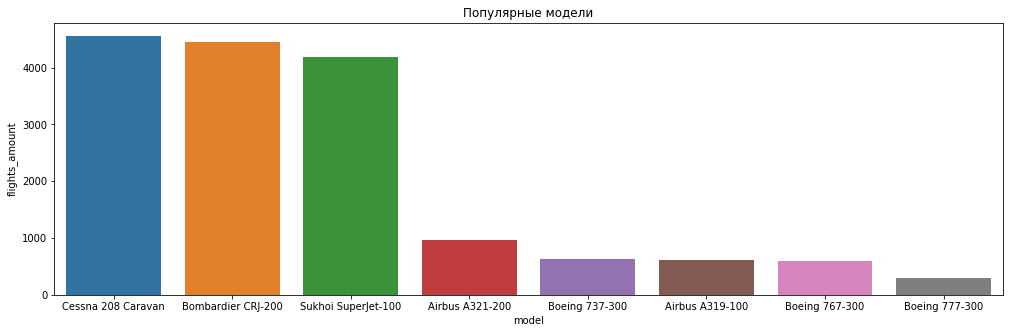

In [ ]:
plt.figure(figsize=(17,5))
sns.barplot(x='model',y='flights_amount', data = frame_model_fl).set_title('Популярные модели');


Без дополнительных вводных, затруднительно анализировать график, просто не понятно, почему корабли Cessna, Bombardier, Sukhoi пробились в тройку лидеров, и вообще, отчего такое распределение. Следует взять общий для всех моделей параметр, по которыму можно пристреляться и оценить возможную причину:

Вместимость:
- Boeing 777-300 вместимость 450 человек
- Boeing 767-300 вместимость 336 человек
- Airbus A319-100 вместимость 156 человек
- Boeing 737-300 вместимость 149 человек
- Airbus A321-200 220 человек
- Sukhoi SuperJet-100 98 человек
- Bombardier CRJ-200 50 человек
- Cessna 208 Caravan вместимость 14 человек


Приведённые параметры взяты из открытых источников и выходят за рамки имеющихся данных. Но хороший аналитик должен смотреть вглубь и до конца, если гипотеза не сформирована = нет движения.

Приняв во внимание доп. параметр самолётов можно сделать вывод, что:

Топ самолёты, которые расчитаны на небольшое число людей, в условиях большой территории и малых городов отлично подходят и раскупаются авиаоператорами как раз для эффективной работы. К тому же, они дешевле в обслуживании. Более крупные модели летают в основном из больших городов, где потоки больше, как говорится редко но метко.

Построение графика «Города и количество рейсов»

In [ ]:
city_av_fl = spark.sql('SELECT * FROM df_2 ORDER BY average_flights DESC')

In [ ]:
frame_city = city_av_fl.toPandas()

Text(0.5, 1.0, 'Города и количество рейсов')

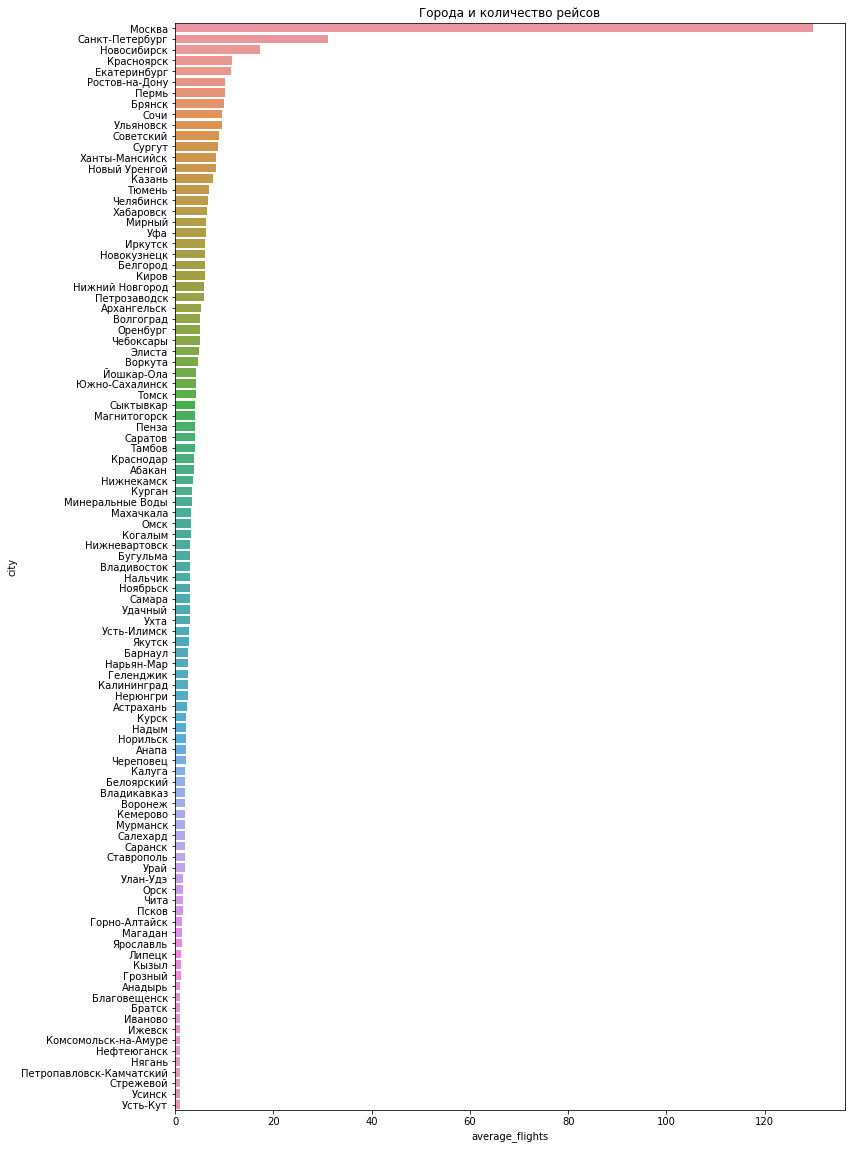

In [ ]:
plt.figure(figsize=(12,20))
sns.barplot(x='average_flights',y='city', data = frame_city).set_title('Города и количество рейсов')

Для точной расстановки приоритетов в полётах, данных недостаточно, так как сезонность играет роль в том числе и некоторые города по числу рейсов могут меняться от месяца к месяцу, на таких статичных данных можно только увидеть, что как и ранее утверждали – чем западнеее и крупнее город – тем больше покупается билетов = совершается рейсов.

Построение графика «Топ-10 городов и количество рейсов»





In [ ]:
frame_city_top = city_top.toPandas()

Text(0.5, 1.0, 'Топ 10 городов')

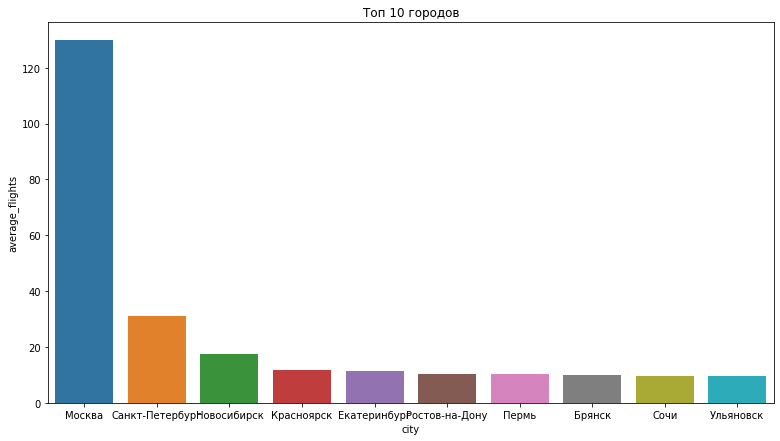

In [ ]:
plt.figure(figsize=(13,7))
sns.barplot(x='city',y='average_flights', data = frame_city_top).set_title('Топ 10 городов')

Как предугадали ранее, среднее зависит от размера города и потока людей, тут ничего удивительного от Москвы и Санкт-Петербурга по нисходящей далее.

## ОБЩИЙ ВЫВОД

Мы загрузили данные с помощью изученной библиотеки pyspark.sql, отработали её инструменты и научились передавать данные через запросы в датафрейм для построения графиков.

По результату аналитики:

График популярности моделей: в условиях больших территорий и большого числа мелких городов, потребность в экономных и компактных моделях отразилась на парке самолётов компании. А другие и не нужны в этой нише.

График со всеми городами: на лицо факт 
- что билеты покупают в туристических городах не так активно в сентябре, продажи идут на спад, хотя сезон не окончен, но сезон отпусков у большинства людей завершён. Например в сравнении по схожему числу населения – Усть-илимск обогнал Геленджик.
- билеты всегда активнее покупают в более западные и крупные города.

Таблица - Топ 10 городов

In [ ]:
frame_city_top = frame_city_top.rename(columns= {'city': 'Город','average_flights': 'Среднее количество рейсов'})
frame_city_top

,Город,Среднее количество рейсов
0,Москва,129.774194
1,Санкт-Петербург,31.161290
2,Новосибирск,17.322581
3,Красноярск,11.580645
4,Екатеринбург,11.322581
5,Ростов-на-Дону,10.193548
6,Пермь,10.129032
7,Брянск,10.000000
8,Сочи,9.612903
9,Ульяновск,9.580645
